# Refined EDA on Silver Layer Datasets

- `silver_transactions.parquet`
- `silver_cards.parquet`
- `silver_users.parquet`
- `silver_mcc_codes.parquet`
- `silver_fraud_labels.parquet`

For each dataset to examine:
1. Shape and preview
2. Missing values
3. Data types
4. Unique values and cardinality
5. Summary statistics
6. Label imbalance (for fraud_labels)
7. Join sanity checks between datasets

Aim: To verify silver layer transformations were applied correctly and to identify any issues before proceeding to the Gold layer.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Filter warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set figure size for all plots
plt.rcParams['figure.figsize'] = [12, 6]

# Define the silver layer data directory
SILVER_DIR = Path("../datamart/silver")

In [2]:
import os
import glob
import pyspark
import pyspark.sql.functions as F


# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

/usr/local/lib/python3.9/dist-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 06:42:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
df.select('date').show(10000)

+-------------------+
|               date|
+-------------------+
|2010-01-01 00:01:00|
|2010-01-01 00:02:00|
|2010-01-01 00:02:00|
|2010-01-01 00:05:00|
|2010-01-01 00:06:00|
|2010-01-01 00:07:00|
|2010-01-01 00:09:00|
|2010-01-01 00:14:00|
|2010-01-01 00:21:00|
|2010-01-01 00:21:00|
|2010-01-01 00:23:00|
|2010-01-01 00:23:00|
|2010-01-01 00:26:00|
|2010-01-01 00:27:00|
|2010-01-01 00:30:00|
|2010-01-01 00:31:00|
|2010-01-01 00:32:00|
|2010-01-01 00:32:00|
|2010-01-01 00:34:00|
|2010-01-01 00:36:00|
|2010-01-01 00:36:00|
|2010-01-01 00:37:00|
|2010-01-01 00:38:00|
|2010-01-01 00:38:00|
|2010-01-01 00:43:00|
|2010-01-01 00:43:00|
|2010-01-01 00:45:00|
|2010-01-01 00:46:00|
|2010-01-01 00:48:00|
|2010-01-01 00:48:00|
|2010-01-01 00:49:00|
|2010-01-01 00:53:00|
|2010-01-01 00:56:00|
|2010-01-01 00:57:00|
|2010-01-01 00:57:00|
|2010-01-01 01:01:00|
|2010-01-01 01:03:00|
|2010-01-01 01:06:00|
|2010-01-01 01:07:00|
|2010-01-01 01:07:00|
|2010-01-01 01:08:00|
|2010-01-01 01:11:00|
|2010-01-0

In [16]:
from pyspark.sql.functions import regexp_replace, to_date, col

df_clean = df.withColumn(
    'date_only',
    to_date(col('date'), 'yyyy-MM-dd HH:mm:ss')  # parse timestamp, keep only date
)

In [18]:
df_clean.select('date_only').show(10)

+----------+
| date_only|
+----------+
|2010-01-01|
|2010-01-01|
|2010-01-01|
|2010-01-01|
|2010-01-01|
|2010-01-01|
|2010-01-01|
|2010-01-01|
|2010-01-01|
|2010-01-01|
+----------+
only showing top 10 rows



In [20]:
from pyspark.sql.functions import min, max
result = df_clean.agg(
    min('date_only').alias('earliest_date'),
    max('date_only').alias('latest_date')
).collect()[0]

print(f"Earliest date: {result['earliest_date']}")
print(f"Latest date: {result['latest_date']}")

[Stage 6:>                                                        (0 + 12) / 12]

Earliest date: 2010-01-01
Latest date: 2019-10-31


In [3]:
df_users = pd.read_csv("../data/users_data.csv")

In [4]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB


## Helper Functions for EDA

In [2]:
def load_dataset(file_name):
    """Load a dataset from the silver layer"""
    file_path = SILVER_DIR / file_name
    return pd.read_parquet(file_path)

In [3]:
def analyze_dataset_basics(df, title):
    """Analyze basic dataset characteristics"""
    
    # Shape
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    
    # Preview
    print("Preview:")
    display(df.head())
    
    # Data Types
    print("\nData Types:")
    display(pd.DataFrame(df.dtypes, columns=['Data Type']))
    
    # Missing Values
    print("\nMissing Values:")
    missing = df.isna().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_percent
    })
    # Only show columns with missing values
    missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
    
    if missing_df.empty:
        print("No missing values found in the dataset!")
    else:
        display(missing_df)

In [4]:
def analyze_cardinality(df):
    """Analyze unique values and cardinality"""
    print("Unique Values and Cardinality:")
    
    # Get columns to analyze based on data type and number of unique values
    id_columns = [col for col in df.columns if 'id' in col.lower()]
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    boolean_columns = [col for col in df.columns if df[col].nunique() <= 2 and col not in id_columns]
    
    # Combine all columns to analyze
    columns_to_analyze = list(set(id_columns + categorical_columns + boolean_columns))
    
    # Create DataFrame with cardinality info
    cardinality_data = []
    for col in columns_to_analyze:
        unique_count = df[col].nunique()
        missing_count = df[col].isna().sum()
        row = {
            'Column': col,
            'Unique Values': unique_count,
            'Missing Values': missing_count,
            'Cardinality %': round((unique_count / len(df)) * 100, 2)
        }
        cardinality_data.append(row)
    
    # Sort by unique values count
    cardinality_df = pd.DataFrame(cardinality_data).sort_values('Unique Values', ascending=False)
    display(cardinality_df)
    
    # Display value distributions for columns with small cardinality
    for col in columns_to_analyze:
        if df[col].nunique() <= 10 and df[col].nunique() > 0 and col not in id_columns:
            print(f"\nDistribution of {col}:")
            value_counts = df[col].value_counts(dropna=False)
            value_percent = df[col].value_counts(dropna=False, normalize=True) * 100
            value_df = pd.DataFrame({
                'Count': value_counts,
                'Percentage': value_percent
            })
            display(value_df)

In [5]:
def analyze_numerical_stats(df):
    """Analyze numerical columns with summary statistics"""
    # Get numerical columns excluding ID columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    id_columns = [col for col in df.columns if 'id' in col.lower()]
    num_cols = [col for col in num_cols if col not in id_columns]
    
    if len(num_cols) > 0:
        print("Numerical Summary Statistics:")
        display(df[num_cols].describe())
    else:
        print("\nNo numerical columns to analyze.")

In [6]:
def analyze_fraud_labels(df):
    """Analyze fraud label distribution"""
    if 'is_fraud_flag' in df.columns:
        print("Fraud Label Distribution:")
        fraud_counts = df['is_fraud_flag'].value_counts()
        fraud_percent = df['is_fraud_flag'].value_counts(normalize=True) * 100
        
        # Create distribution table
        fraud_df = pd.DataFrame({
            'Count': fraud_counts,
            'Percentage': fraud_percent
        })
        fraud_df.index = ['Not Fraud (0)', 'Fraud (1)'] if len(fraud_df) == 2 else fraud_df.index
        display(fraud_df)
        
        # Visualize distribution
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x='is_fraud_flag', data=df, palette='coolwarm')
        
        # Add count and percentage labels
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            label = f"{height:,} ({fraud_percent.iloc[i]:.2f}%)"
            ax.annotate(label, 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='bottom', fontsize=12)
        
        plt.title('Fraud vs. Non-Fraud Distribution')
        plt.xlabel('Is Fraud')
        plt.ylabel('Count')
        plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
        plt.tight_layout()
        plt.show()

In [7]:
def perform_full_eda(file_name):
    """Perform complete EDA on a dataset"""
    df = load_dataset(file_name)
    analyze_dataset_basics(df, file_name)
    analyze_cardinality(df)
    analyze_numerical_stats(df)
    
    # Only for fraud labels dataset
    if 'fraud_labels' in file_name:
        analyze_fraud_labels(df)
        
    return df

# 1. Silver Transactions Dataset Analysis

In [8]:
transactions_df = perform_full_eda('silver_transactions.parquet')

Shape: 13305915 rows, 17 columns
Preview:


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_refund,is_online_merchant,has_merchant_state,has_zip,has_error
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,swipe,59935,beulah,ND,58523.0,5499,None,1,0,1,1,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,swipe,67570,bettendorf,IA,52722.0,5311,None,0,0,1,1,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,swipe,27092,vista,CA,92084.0,4829,None,0,0,1,1,0
3,7475331,2010-01-01 00:05:00,430,2860,200.00,swipe,27092,crown point,IN,46307.0,4829,None,0,0,1,1,0
4,7475332,2010-01-01 00:06:00,848,3915,46.41,swipe,13051,harwood,MD,20776.0,5813,None,0,0,1,1,0



Data Types:


,Data Type
id,object
date,datetime64[ns]
client_id,object
card_id,object
amount,float32
use_chip,object
merchant_id,object
merchant_city,object
merchant_state,object
zip,object



Missing Values:


,Missing Values,Percentage
errors,13094522,98.411286
zip,1652706,12.420837
merchant_state,1563700,11.751916


Unique Values and Cardinality:


,Column,Unique Values,Missing Values,Cardinality %
12,id,13305915,0,100.00
10,merchant_id,74831,0,0.56
14,zip,25256,1652706,0.19
9,merchant_city,12492,0,0.09
8,card_id,4071,0,0.03
3,client_id,1219,0,0.01
4,merchant_state,199,1563700,0.00
0,mcc,109,0,0.00
5,errors,22,13094522,0.00
11,use_chip,3,0,0.00



Distribution of has_zip:


,Count,Percentage
has_zip,,
1,11653209,87.579163
0,1652706,12.420837



Distribution of has_error:


,Count,Percentage
has_error,,
0,13094522,98.411286
1,211393,1.588714



Distribution of is_refund:


,Count,Percentage
is_refund,,
0,12645866,95.039432
1,660049,4.960568



Distribution of is_online_merchant:


,Count,Percentage
is_online_merchant,,
0,11742215,88.248084
1,1563700,11.751916



Distribution of use_chip:


,Count,Percentage
use_chip,,
swipe,6967185,52.361563
chip,4780818,35.930021
online,1557912,11.708417



Distribution of has_merchant_state:


,Count,Percentage
has_merchant_state,,
1,11742215,88.248084
0,1563700,11.751916



No numerical columns to analyze.


In [9]:
# Total online transactions
online_total = transactions_df[transactions_df['is_online_merchant'] == 1].shape[0]

# Online transactions with missing merchant_state
online_missing = transactions_df[(transactions_df['is_online_merchant'] == 1) & (transactions_df['merchant_state'].isna())].shape[0]

# Offline transactions with missing merchant_state
offline_missing = transactions_df[(transactions_df['is_online_merchant'] == 0) & (transactions_df['merchant_state'].isna())].shape[0]

# Results
print(f"Online total: {online_total}")
print(f"Online missing merchant_state: {online_missing}")
print(f"Offline missing merchant_state: {offline_missing}")
if online_total > 0:
    print(f"Percent of online missing merchant_state: {online_missing / online_total:.2%}")


Online total: 1563700
Online missing merchant_state: 1563700
Offline missing merchant_state: 0
Percent of online missing merchant_state: 100.00%


Insight from above cell: merchant_state is only blank because it is online transactions 
Therefore, we can safely impute 'ONLINE' in this column for Gold Layer (if necessary) else we can also use the column `is_online_merchant`

### Purpose of the below cell:
To explore if there are any observable patterns associated with the columns has_error, has_zip, and is_refund.

Limitation:
These insights are exploratory and may not be meaningful on their own, since this dataset has not yet been joined with fraud labels. <br>
Without is_fraud_flag, we cannot evaluate actual fraud correlation or predictive power.

In [10]:
print("\nFirst 5 rows with has_error == 1:\n")
display(transactions_df[transactions_df['has_error'] == 1].head(5))

print("\nFirst 5 rows with has_zip == 0:\n")
display(transactions_df[transactions_df['zip'].isna()].head(5))

print("\nFirst 5 rows with is_refund == 1:\n")
display(transactions_df[transactions_df['is_refund'] == 1].head(5))


First 5 rows with has_error == 1:



,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_refund,is_online_merchant,has_merchant_state,has_zip,has_error
166,7475516,2010-01-01 04:56:00,464,3233,104.099998,swipe,32175,orlando,FL,32804.0,7538,Technical Glitch,0,0,1,1,1
248,7475611,2010-01-01 06:10:00,1797,1127,28.840000,online,15143,online,None,None,4784,Bad Expiration,0,1,0,0,1
275,7475643,2010-01-01 06:19:00,1797,1127,38.580002,online,15143,online,None,None,4784,Bad Card Number,0,1,0,0,1
401,7475792,2010-01-01 07:02:00,1424,4710,-72.000000,swipe,59935,kingman,AZ,86401.0,5499,Insufficient Balance,1,0,1,1,1
483,7475881,2010-01-01 07:22:00,843,184,37.540001,swipe,89462,terre haute,IN,47805.0,5300,Insufficient Balance,0,0,1,1,1



First 5 rows with has_zip == 0:



,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_refund,is_online_merchant,has_merchant_state,has_zip,has_error
7,7475335,2010-01-01 00:14:00,1684,2140,26.459999,online,39021,online,None,None,4784,None,0,1,0,0,0
8,7475336,2010-01-01 00:21:00,335,5131,261.579987,online,50292,online,None,None,7801,None,0,1,0,0,0
18,7475346,2010-01-01 00:34:00,394,4717,26.040001,online,39021,online,None,None,4784,None,0,1,0,0,0
24,7475353,2010-01-01 00:43:00,301,3742,10.170000,online,39021,online,None,None,4784,None,0,1,0,0,0
26,7475356,2010-01-01 00:45:00,566,3439,16.860001,online,16798,online,None,None,4121,None,0,1,0,0,0



First 5 rows with is_refund == 1:



,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_refund,is_online_merchant,has_merchant_state,has_zip,has_error
0,7475327,2010-01-01 00:01:00,1556,2972,-77.0,swipe,59935,beulah,ND,58523.0,5499,None,1,0,1,1,0
19,7475347,2010-01-01 00:36:00,114,3398,-64.0,swipe,61195,north hollywood,CA,91606.0,5541,None,1,0,1,1,0
50,7475382,2010-01-01 01:25:00,1703,2969,-78.0,swipe,43293,grand junction,CO,81506.0,5499,None,1,0,1,1,0
81,7475422,2010-01-01 02:13:00,1453,1117,-460.0,swipe,5009,middletown,NY,10940.0,7011,None,1,0,1,1,0
114,7475460,2010-01-01 03:08:00,957,4532,-147.0,swipe,44795,marysville,OH,43040.0,3780,None,1,0,1,1,0


In [11]:
# Check zip format & length
transactions_df['zip'] = transactions_df['zip'].astype(str)
transactions_df['zip'].value_counts().head(10)
transactions_df['zip'].str.len().value_counts()

zip
7    10850209
4     1652706
6      803000
Name: count, dtype: int64

<Axes: xlabel='amount', ylabel='Count'>

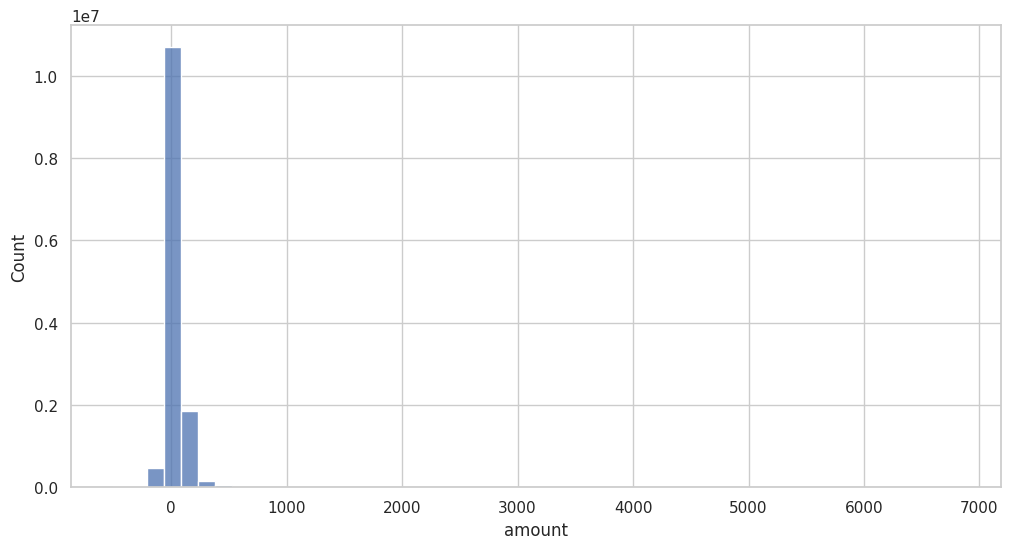

In [12]:
# Check amount distribution

sns.histplot(transactions_df['amount'], bins=50)

<Axes: title={'center': 'Monthly Transaction Volume'}, xlabel='date'>

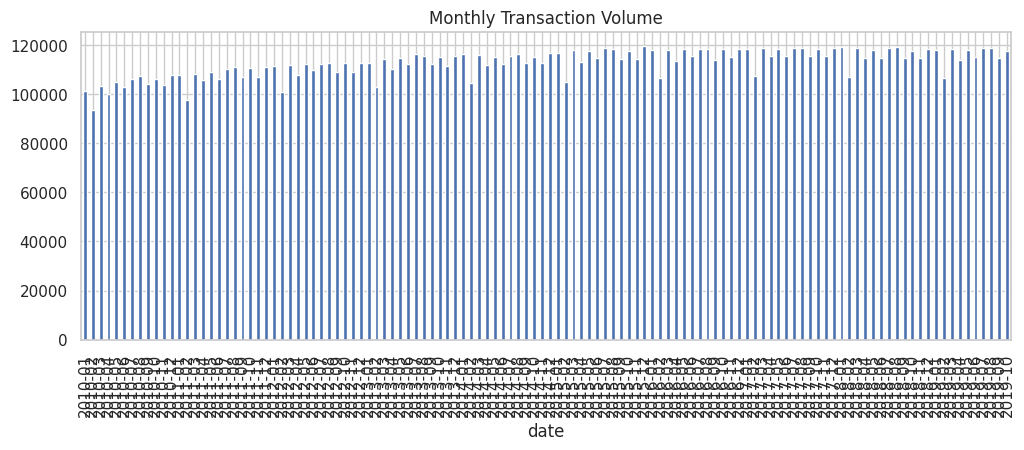

In [13]:
# Check distribution of Transactions
monthly_counts = transactions_df['date'].dt.to_period('M').value_counts().sort_index()
monthly_counts.plot(kind='bar', figsize=(12, 4), title='Monthly Transaction Volume')

In [14]:
print("Unique error values:")
display(transactions_df['errors'].dropna().unique())

# Optional: view frequencies if many types exist
print("\nError value counts:")
display(transactions_df['errors'].value_counts(dropna=True))


Unique error values:


array(['Technical Glitch', 'Bad Expiration', 'Bad Card Number',
       'Insufficient Balance', 'Bad PIN', 'Bad CVV', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Technical Glitch', 'Bad Expiration,Bad CVV',
       'Bad CVV,Insufficient Balance', 'Bad Card Number,Technical Glitch',
       'Bad Zipcode,Insufficient Balance', 'Bad Zipcode,Technical Glitch',
       'Bad Card Number,Bad Expiration,Insufficient Balance'],
      dtype=object)


Error value counts:


errors
Insufficient Balance                                   130902
Bad PIN                                                 32119
Technical Glitch                                        26271
Bad Card Number                                          7767
Bad Expiration                                           6161
Bad CVV                                                  6106
Bad Zipcode                                              1126
Bad PIN,Insufficient Balance                              293
Insufficient Balance,Technical Glitch                     243
Bad Card Number,Insufficient Balance                       71
Bad PIN,Technical Glitch                                   70
Bad CVV,Insufficient Balance                               57
Bad Expiration,Insufficient Balance                        47
Bad Card Number,Bad CVV                                    38
Bad Card Number,Bad Expiration                             33
Bad Expiration,Bad CVV                                     32
B

Text(0.5, 1.0, 'Correlation Heatmap of Key Transaction Features')

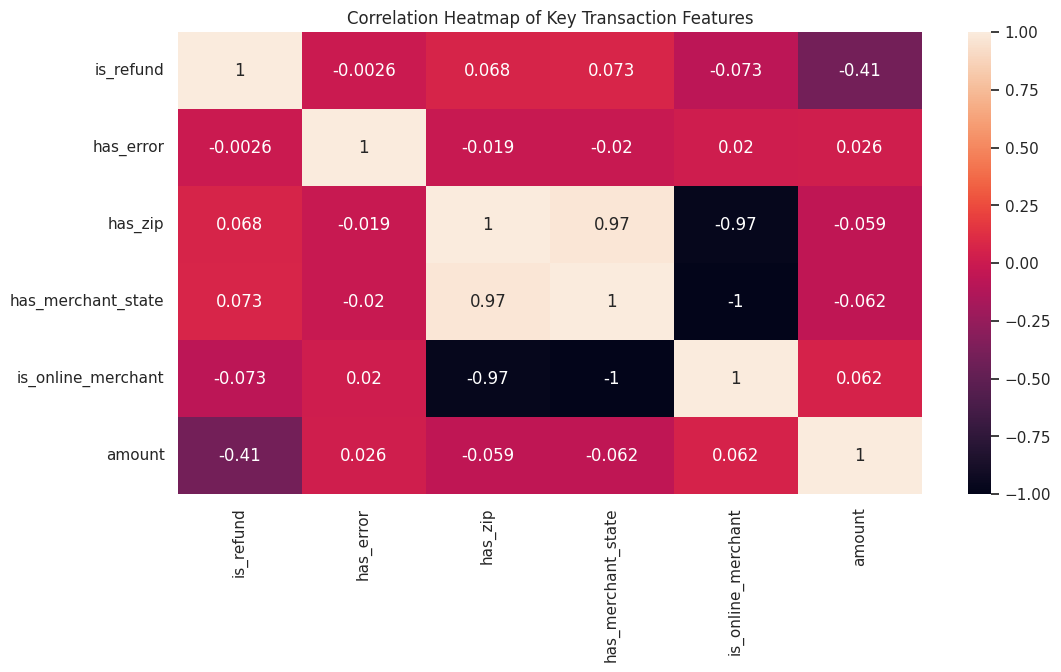

In [15]:
# Check Correlation

sns.heatmap(transactions_df[['is_refund', 'has_error', 'has_zip', 'has_merchant_state', 'is_online_merchant', 'amount']].corr(), annot=True)
plt.title("Correlation Heatmap of Key Transaction Features")

# 2. Silver Cards Dataset Analysis

In [16]:
cards_df = perform_full_eda('silver_cards.parquet')

Shape: 6146 rows, 13 columns
Preview:


,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,visa,debit,4344676511950444,2022-12-01,623,1,2,24295.0,2002-09-01,2008,0
1,2731,825,visa,debit,4956965974959986,2020-12-01,393,1,2,21968.0,2014-04-01,2014,0
2,3701,825,visa,debit,4582313478255491,2024-02-01,719,1,2,46414.0,2003-07-01,2004,0
3,42,825,visa,credit,4879494103069057,2024-08-01,693,0,1,12400.0,2003-01-01,2012,0
4,4659,825,mastercard,debit (prepaid),5722874738736011,2009-03-01,75,1,1,28.0,2008-09-01,2009,0



Data Types:


,Data Type
id,object
client_id,object
card_brand,object
card_type,object
card_number,object
expires,datetime64[ns]
cvv,object
has_chip,int32
num_cards_issued,int32
credit_limit,float32



Missing Values:
No missing values found in the dataset!
Unique Values and Cardinality:


,Column,Unique Values,Missing Values,Cardinality %
7,id,6146,0,100.00
4,card_number,6146,0,100.00
0,client_id,2000,0,32.54
3,cvv,998,0,16.24
1,card_brand,4,0,0.07
5,card_type,3,0,0.05
2,has_chip,2,0,0.03
6,card_on_dark_web,1,0,0.02



Distribution of card_brand:


,Count,Percentage
card_brand,,
mastercard,3209,52.212821
visa,2326,37.845753
amex,402,6.540840
discover,209,3.400586



Distribution of has_chip:


,Count,Percentage
has_chip,,
1,5500,89.489099
0,646,10.510901



Distribution of card_type:


,Count,Percentage
card_type,,
debit,3511,57.126586
credit,2057,33.468923
debit (prepaid),578,9.404491



Distribution of card_on_dark_web:


,Count,Percentage
card_on_dark_web,,
0,6146,100.0



No numerical columns to analyze.


In [17]:
# Check CVV length

cards_df['cvv'] = cards_df['cvv'].astype(str)
cards_df['cvv'].str.len().value_counts()

cvv
3    5529
2     562
1      55
Name: count, dtype: int64

In [34]:
# CVV only has 998 unique values (weird?)
# To check if the CVV is real/fake with length (3 or more digits = valid; else 0)

cards_df['cvv_available'] = cards_df['cvv'].str.len().apply(lambda x: 1 if x >= 3 else 0)
cards_df['cvv_available'].value_counts()


cvv_available
1    5529
0     617
Name: count, dtype: int64

<Axes: xlabel='num_cards_issued', ylabel='Count'>

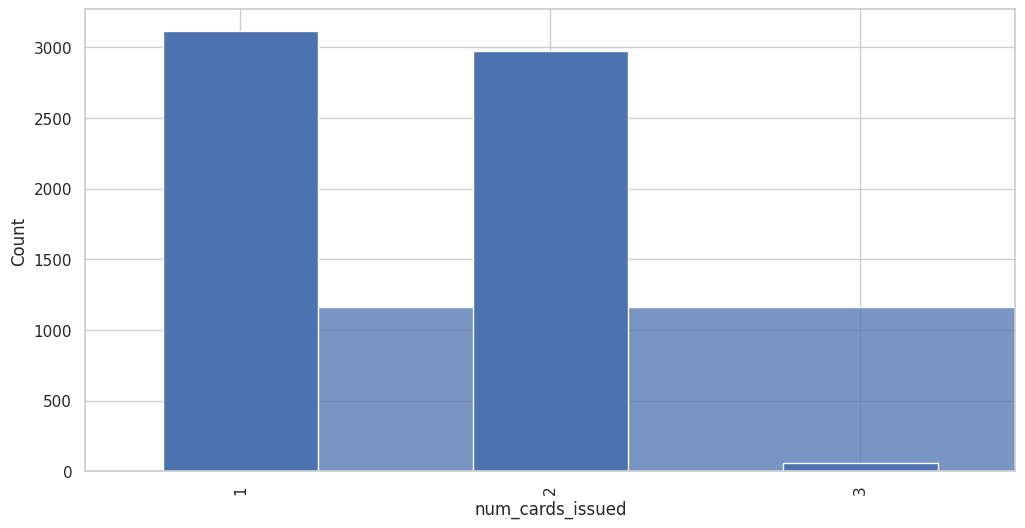

In [19]:
# Check Numeric Feature Distribution

sns.histplot(cards_df['credit_limit'], bins=30)
cards_df['num_cards_issued'].value_counts().plot(kind='bar')


In [20]:
# Check Card Brands Has What Types

pd.crosstab(cards_df['card_brand'], cards_df['card_type'])

card_type,credit,debit,debit (prepaid)
card_brand,,,
amex,402,0,0
discover,209,0,0
mastercard,635,2191,383
visa,811,1320,195


In [21]:
# Check Date Range
print("Account Open Date Range:", cards_df['acct_open_date'].min(), "→", cards_df['acct_open_date'].max())
print("Expiry Date Range:", cards_df['expires'].min(), "→", cards_df['expires'].max())
print(cards_df['year_pin_last_changed'].describe())


Account Open Date Range: 1991-01-01 00:00:00 → 2020-02-01 00:00:00
Expiry Date Range: 1997-07-01 00:00:00 → 2024-12-01 00:00:00
count    6146.000000
mean     2013.436707
std         4.270699
min      2002.000000
25%      2010.000000
50%      2013.000000
75%      2017.000000
max      2020.000000
Name: year_pin_last_changed, dtype: float64


# 3. Silver Users Dataset Analysis

In [22]:
users_df = perform_full_eda('silver_users.parquet')

Shape: 2000 rows, 14 columns
Preview:


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,female,462 rose lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,1746,53,68,1966,12,female,3606 federal boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5
2,1718,81,67,1938,11,female,766 third drive,34.02,-117.89,22681.0,33483.0,196.0,698,5
3,708,63,63,1957,1,female,3 madison street,40.71,-73.99,163145.0,249925.0,202328.0,722,4
4,1164,43,70,1976,9,male,9620 valley stream drive,37.76,-122.44,53797.0,109687.0,183855.0,675,1



Data Types:


,Data Type
id,object
current_age,int32
retirement_age,int32
birth_year,int32
birth_month,int32
gender,object
address,object
latitude,float64
longitude,float64
per_capita_income,float32



Missing Values:
No missing values found in the dataset!
Unique Values and Cardinality:


,Column,Unique Values,Missing Values,Cardinality %
1,id,2000,0,100.00
0,address,1999,0,99.95
2,gender,2,0,0.10



Distribution of gender:


,Count,Percentage
gender,,
female,1016,50.8
male,984,49.2


Numerical Summary Statistics:


,latitude,longitude
count,2000.000000,2000.000000
mean,37.389225,-91.554765
std,5.114324,16.283293
min,20.880000,-159.410000
25%,33.837500,-97.395000
50%,38.250000,-86.440000
75%,41.200000,-80.130000
max,61.200000,-68.670000


<Axes: xlabel='num_credit_cards', ylabel='Count'>

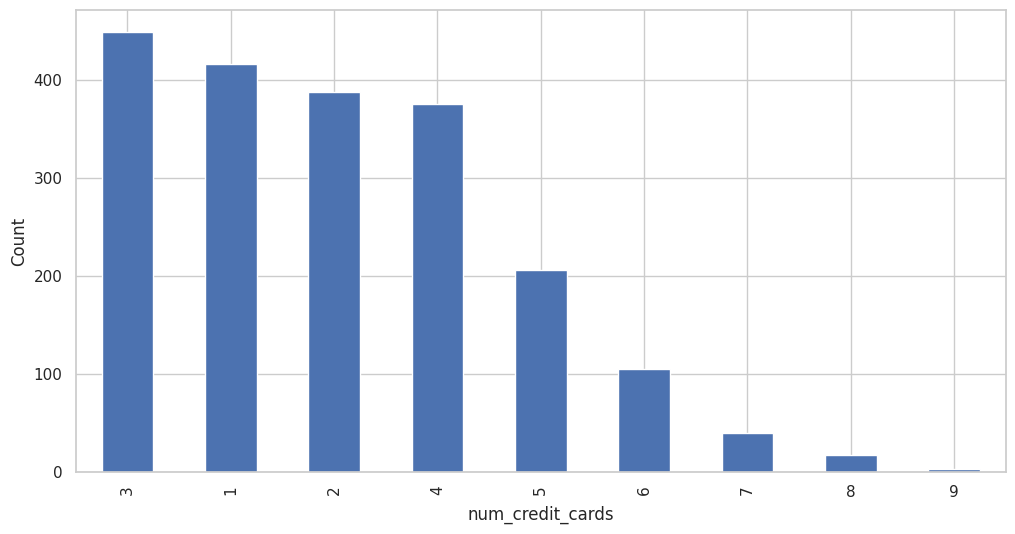

In [23]:
# Check Value Distributions

sns.histplot(users_df['credit_score'], bins=30)
users_df['num_credit_cards'].value_counts().plot(kind='bar')

In [24]:
# Check Income & Debt

print(users_df[['per_capita_income', 'yearly_income', 'total_debt']].describe())

       per_capita_income  yearly_income     total_debt
count        2000.000000    2000.000000    2000.000000
mean        23141.927734   45715.882812   63709.695312
std         11324.137695   22992.615234   52254.453125
min             0.000000       1.000000       0.000000
25%         16824.500000   32818.500000   23986.750000
50%         20581.000000   40744.500000   58251.000000
75%         26286.000000   52698.500000   89070.500000
max        163145.000000  307018.000000  516263.000000


<Axes: xlabel='current_age', ylabel='retirement_age'>

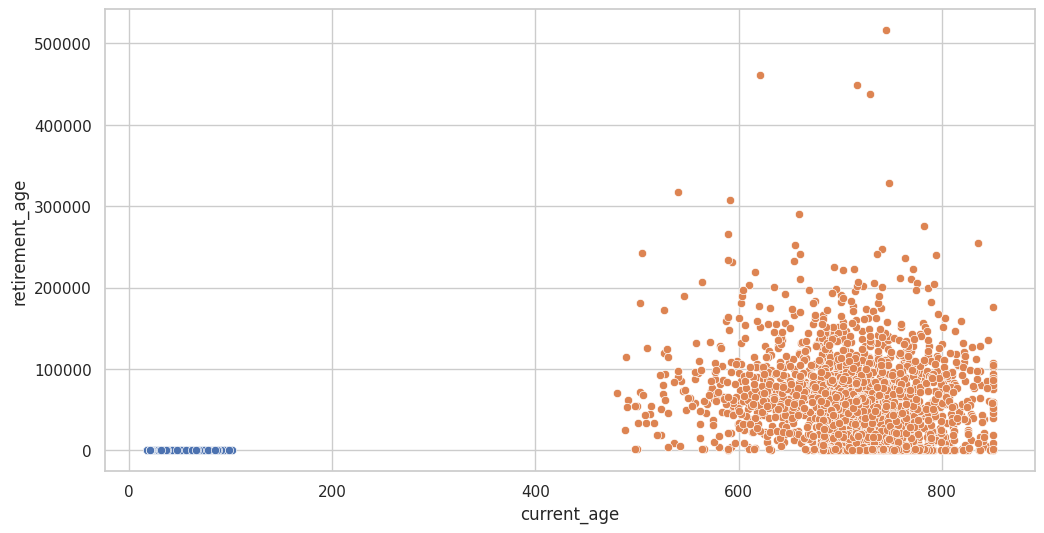

In [25]:
# Check Relationship 

sns.scatterplot(data=users_df, x='current_age', y='retirement_age')
sns.scatterplot(data=users_df, x='credit_score', y='total_debt')

# 4. Silver MCC Codes Dataset Analysis

In [26]:
mcc_df = perform_full_eda('silver_mcc_codes.parquet')

Shape: 109 rows, 2 columns
Preview:


,mcc_code,mcc_description
0,7230,beauty and barber shops
1,3390,miscellaneous metalwork
2,7922,theatrical producers
3,3722,passenger railways
4,5651,family clothing stores



Data Types:


,Data Type
mcc_code,object
mcc_description,object



Missing Values:
No missing values found in the dataset!
Unique Values and Cardinality:


,Column,Unique Values,Missing Values,Cardinality %
0,mcc_code,109,0,100.00
1,mcc_description,108,0,99.08



No numerical columns to analyze.


# 5. Silver Fraud Labels Dataset Analysis

Shape: 8914963 rows, 3 columns
Preview:


,transaction_id,is_fraud,is_fraud_flag
0,16366130,no,0
1,12981029,no,0
2,23272959,no,0
3,18317767,no,0
4,7572018,no,0



Data Types:


,Data Type
transaction_id,object
is_fraud,object
is_fraud_flag,int32



Missing Values:
No missing values found in the dataset!
Unique Values and Cardinality:


,Column,Unique Values,Missing Values,Cardinality %
1,transaction_id,8914963,0,100.0
0,is_fraud,2,0,0.0
2,is_fraud_flag,2,0,0.0



Distribution of is_fraud:


,Count,Percentage
is_fraud,,
no,8901631,99.850454
yes,13332,0.149546



Distribution of is_fraud_flag:


,Count,Percentage
is_fraud_flag,,
0,8901631,99.850454
1,13332,0.149546



No numerical columns to analyze.
Fraud Label Distribution:


,Count,Percentage
Not Fraud (0),8901631,99.850454
Fraud (1),13332,0.149546


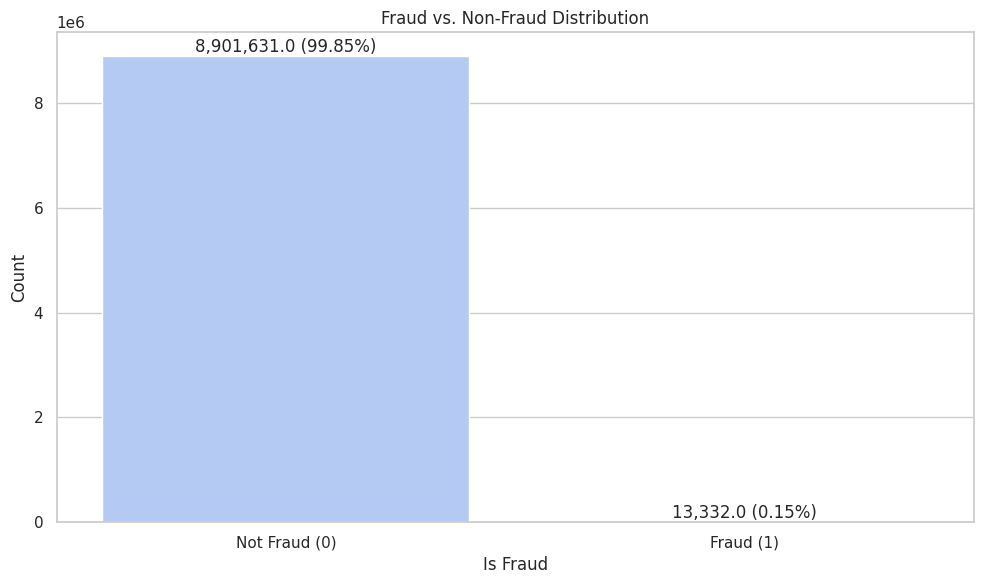

In [27]:
fraud_df = perform_full_eda('silver_fraud_labels.parquet')

<Axes: title={'center': 'Rolling Fraud Rate (per 100K transactions)'}>

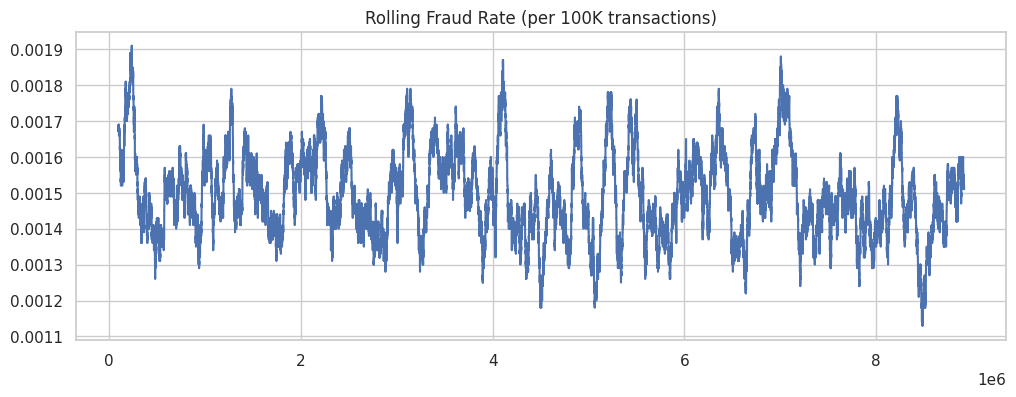

In [28]:
# To see how fraud changes overtime

rolling_fraud_rate = fraud_df['is_fraud_flag'].rolling(100000).mean()
rolling_fraud_rate.plot(title="Rolling Fraud Rate (per 100K transactions)", figsize=(12, 4))

# 6. Join Checks

## 6.1 Transaction IDs Across Datasets

In [29]:
# Check if all transaction_ids in fraud_labels exist in transactions
if 'transaction_id' in fraud_df.columns and 'id' in transactions_df.columns:
    fraud_transaction_ids = set(fraud_df['transaction_id'])
    transaction_ids = set(transactions_df['id'])
    
    # Find transaction IDs in fraud labels but not in transactions
    missing_in_transactions = fraud_transaction_ids - transaction_ids
    
    print("\nTransaction ID Validation:")
    
    if missing_in_transactions:
        print(f"WARNING: Found {len(missing_in_transactions)} transaction IDs in fraud_labels that don't exist in transactions.")
        print(f"Example missing IDs: {list(missing_in_transactions)[:5]}")
    else:
        print("All transaction IDs in fraud_labels exist in transactions dataset.")
    
    # Find transaction IDs not labeled in fraud dataset
    unlabeled_transactions = transaction_ids - fraud_transaction_ids
    unlabeled_percent = (len(unlabeled_transactions) / len(transaction_ids)) * 100
    
    print(f"\nUnlabeled Transactions: {len(unlabeled_transactions)} out of {len(transaction_ids)} ({unlabeled_percent:.2f}%)")


Transaction ID Validation:
All transaction IDs in fraud_labels exist in transactions dataset.

Unlabeled Transactions: 4390952 out of 13305915 (33.00%)


## 6.2 Client IDs Across Datasets

In [30]:
# Check client_ids across datasets
transaction_client_ids = set(transactions_df['client_id']) if 'client_id' in transactions_df.columns else set()
cards_client_ids = set(cards_df['client_id']) if 'client_id' in cards_df.columns else set()
users_ids = set(users_df['id']) if 'id' in users_df.columns else set()

print("\nClient ID Validation:")

# Check client_ids in transactions that don't exist in cards
if transaction_client_ids and cards_client_ids:
    clients_missing_in_cards = transaction_client_ids - cards_client_ids
    if clients_missing_in_cards:
        print(f"WARNING: Found {len(clients_missing_in_cards)} client IDs in transactions that don't exist in cards.")
        print(f"Example missing IDs: {list(clients_missing_in_cards)[:5]}")
    else:
        print("All client IDs in transactions exist in the cards dataset.")

# Check client_ids in cards that don't exist in users
if cards_client_ids and users_ids:
    clients_missing_in_users = cards_client_ids - users_ids
    if clients_missing_in_users:
        print(f"WARNING: Found {len(clients_missing_in_users)} client IDs in cards that don't exist in users.")
        print(f"Example missing IDs: {list(clients_missing_in_users)[:5]}")
    else:
        print("All client IDs in cards exist in the users dataset.")


Client ID Validation:
All client IDs in transactions exist in the cards dataset.
All client IDs in cards exist in the users dataset.


## 6.3 Card IDs Across Datasets

In [31]:
# Check card_ids across datasets
transaction_card_ids = set(transactions_df['card_id']) if 'card_id' in transactions_df.columns else set()
cards_ids = set(cards_df['id']) if 'id' in cards_df.columns else set()

print("\nCard ID Validation:")

# Check card_ids in transactions that don't exist in cards
if transaction_card_ids and cards_ids:
    cards_missing_in_cards = transaction_card_ids - cards_ids
    if cards_missing_in_cards:
        print(f"WARNING: Found {len(cards_missing_in_cards)} card IDs in transactions that don't exist in cards.")
        print(f"Example missing IDs: {list(cards_missing_in_cards)[:5]}")
    else:
        print("All card IDs in transactions exist in the cards dataset.")


Card ID Validation:
All card IDs in transactions exist in the cards dataset.


## 6.4 MCC Codes Across Datasets

In [32]:
# Check MCC codes across datasets
transaction_mcc_codes = set(transactions_df['mcc']) if 'mcc' in transactions_df.columns else set()
mcc_codes = set(mcc_df['mcc_code']) if 'mcc_code' in mcc_df.columns else set()

print("\nMCC Code Validation:")

# Check MCC codes in transactions that don't exist in MCC codes dataset
if transaction_mcc_codes and mcc_codes:
    mcc_missing_in_codes = transaction_mcc_codes - mcc_codes
    if mcc_missing_in_codes:
        print(f"WARNING: Found {len(mcc_missing_in_codes)} MCC codes in transactions that don't exist in the MCC codes dataset.")
        print(f"Example missing codes: {list(mcc_missing_in_codes)[:5]}")
    else:
        print("All MCC codes in transactions exist in the MCC codes dataset.")


MCC Code Validation:
All MCC codes in transactions exist in the MCC codes dataset.


# 7. Summary of Findings

## 7.1 Data Quality Assessment

### Transactions Dataset
- Verified schema with appropriate data types: string IDs, datetime for transaction date, float for amount
- Mix of online and in-person transactions captured via `is_online_merchant`
- Derived flags such as `has_zip`, `has_error`, and `is_refund` included
- Missing values noted in `errors`, `merchant_state` (for online transactions), and `zip` — retained for downstream modeling

### Cards Dataset
- Clean distribution of `card_type` and `card_brand`
- Presence of chip technology captured in `has_chip`
- No flagged cards found in `card_on_dark_web` column
- Low uniqueness observed in `cvv`; converted to binary indicator `cvv_available`
- `acct_open_date` and `expires` default to day `01` — to only refer to MM and YYYY of all dates (DD is dummy)

### Users Dataset
- No missing values detected
- Gender distribution is balanced
- Income, debt, and credit score distributions align with expectations
- Latitude and longitude fall within plausible U.S. boundaries (can be dropped if unused)

### MCC Codes Dataset
- Clean mapping of `mcc_code` to `mcc_description`
- Fully standardized and ready for join enrichment

### Fraud Labels Dataset
- High class imbalance present in fraud labels (`is_fraud_flag`)
- Visualizations include bar plot and rolling fraud density over index
- `transaction_id` is unique and clean
- No missing values

## 7.2 Join Integrity Checks

- `transaction_id` validated for join with fraud labels
- `card_id`, `client_id`, and `mcc` successfully validated against cards, users, and MCC datasets
- Join structure is consistent and ready for Gold Layer integration

## 7.3 Next Steps

### Finalize Gold Layer Assembly
- Use transactions as the base table
- Join with cards (card_id), users (client_id), mcc_codes (mcc), and fraud_labels (id <--> transaction_id) on appropriate keys

Example:<br>
df = transactions_df \
    .join(cards_df, on="card_id", how="left") \
    .join(users_df, on="client_id", how="left") \
    .join(mcc_codes_df, on="mcc", how="left") \
    .join(fraud_labels_df, transactions_df["id"] == fraud_labels_df["transaction_id"], "left")

- Apply type casting, imputation, and final validation
- Prepare output files:
  - `features_gold.parquet`
  - `labels_gold.parquet`

### Gold Feature Schema Guidelines
- Convert or drop low-utility columns like `cvv`, `errors`
- Retain placeholder dates where necessary, or derive month-based features
- Consider additional engineered features such as:
  - Temporal (e.g., transaction hour)
  - Behavioral (e.g., credit utilization)

### Class Imbalance Strategy
- Fraud label is highly imbalanced
- Recommended approaches:
  - Class weights in model training
  - Undersampling or other resampling techniques during experimentation
  - Evaluation via metrics such as F1-score, precision-recall AUC

### Model Pipeline Plan
| Model                  | Notes                                 |
|------------------------|----------------------------------------|
| XGBoost                | Primary baseline, includes SHAP support |
| Logistic Regression    | Interpretable baseline model            |
| Random Forest          | Optional — similar to XGBoost           |
| Deep Learning (MLP)    | Optional — consider only if justified   |

*SHAP:
- SHAP assigns a contribution score to each feature for each prediction --> so we know which features pushed the prediction higher or lower
- XGBoost has native SHAP integration

### Handling Unlabeled Transactions
- To be dropped since our focus is only on supervised learning, I assume.
